In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import re
sns.set(style="whitegrid")
%matplotlib inline

In [27]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

onetdict ={'11': 'Management Occupations',
           '13': 'Business and Financial Operations Occupations',
           '15': 'Computer and Mathematical Occupations',
           '17': 'Architecture and Engineering Occupations',
           '19': 'Life, Physical, and Social Science Occupations',
           '21': 'Community and Social Service Occupations',
           '23': 'Legal Occupations',
           '25': 'Education, Training, and Library Occupations',
           '27': 'Arts, Design, Entertainment, Sports, and Media Occupations',
           '29': 'Healthcare Practitioners and Technical Occupations',
           '31': 'Healthcare Support Occupations',
           '33': 'Protective Service Occupations',
           '35': 'Food Preparation and Serving Related Occupations',
           '37': 'Building and Grounds Cleaning and Maintenance',
           '39': 'Personal Care and Service Occupations',
           '41': 'Sales and Related Occupations', 
           '43': 'Office and Administrative Support Occupations',
           '45': 'Farming, Fishing, and Forestry Occupations',
           '47': 'Construction and Extraction Occupations', 
           '49': 'Installation, Maintenance, and Repair Occupations', 
           '51': 'Production Occupations', 
           '53': 'Transportation and Material Moving Occupations', 
           '55': 'Military Specific Occupations',
           '99': 'Unknown'}

## Load VA dataset

In [3]:
df = pd.read_csv('joblistings.merged.parsed.unique.grpbyyear.2010-2015.01.tsv',sep='\t', dtype={"educationRequirements": str})    

In [4]:
print len(df)

360000


In [5]:
print len(df['title'].unique())
print df['title'].unique()

163945
['Maintenance Groundskeeper' 'Pre Need Benefit Advisor'
 'Sales Representative' ..., 'Home Loan Consultant'
 'Material Handler (Forklift And Stand-Up Reach Driver)'
 'Supervisor- Accounts Payable/Receivable']


In [6]:
onet = df['normalizedTitle_onetCode']
onet.describe()

count         349892
unique           489
top       11-9051.00
freq           11420
Name: normalizedTitle_onetCode, dtype: object

## Cleaning

**Column of interest:** 
- 'title', 'normalizedTitle_onetCode', 'normalizedTitle_onetName','jobDescription', 'educationRequirements','qualifications','responsibilities','skills'

**Basic cleaning and preprocessing**:
- Get rid of punctuations and numbers
- Set in lowercase
- Tokenize and de-accent


In [7]:
document = df['title'].str.cat([df['normalizedTitle_onetName'], df['jobDescription'], df['educationRequirements'],df['qualifications'],df['skills']], sep=' ',na_rep='')

In [8]:
for i, context in document.iteritems():
    document[i] = " ".join(gensim.utils.simple_preprocess(clean_str(context)))

**imputation in normalizedTitle_onetCode:**
- Data quality is relatively good in terms of missing value
- There are 4069 entries with normalizedTitle_onetCode 99-9999.00 and 10108 entries with normalizedTitle_onetCode NaN
- 99-9999.00 is not a valid onet code, so let's assume they are unknown type of occupation. 
- Impute NaN with 99-9999.00

In [11]:
print "Invalid onet code: ", df[df['normalizedTitle_onetCode']=='99-9999.00']['id'].count()
print "Missing values: ", df['normalizedTitle_onetCode'].isnull().sum()


Invalid onet code:  4069
Missing values:  10108


In [12]:
onet_code = df['normalizedTitle_onetCode'].fillna('99-9999.00')

**Extract major group**
- ONET Standard Occupational Classification has five layers:
    - **```First layer: 23 standard major groups (job categories)```**
    - Second layer: Minor groups
    - Third layer: Broad Occupations
    - Forth layer: Detailed Occupations
    - Fifth layer: Onet 2010 SOC occupations

In [13]:
major_group = pd.Series(map(lambda row: row[:2],onet_code))

In [14]:
print "Major groups: ", major_group.unique()
print "Number of major groups: ", len(major_group.unique())

Major groups:  ['37' '13' '41' '11' '15' '99' '43' '51' '53' '27' '35' '19' '17' '25' '39'
 '29' '33' '21' '23' '47' '31' '49' '45' '55']
Number of major groups:  24


## Build Corpus

In [15]:
df_clean = pd.DataFrame({'onet_code': onet_code, 'major_group': major_group, 'documents': document})

In [16]:
df_clean.head(n=5)

,documents,major_group,onet_code
0,maintenance groundskeeper janitors and cleaner...,37,37-2011.00
1,pre need benefit advisor compensation benefits...,13,13-1141.00
2,pre need benefit advisor compensation benefits...,13,13-1141.00
3,sales representative sales representatives who...,41,41-4012.00
4,sales manager sales managers sales manager pit...,11,11-2022.00


## Exploration

In [17]:
average_word_count = {}
for m in df_clean['major_group'].unique():
    word_count=0
    sum_doc = 0.0
    for doc in df_clean[df_clean['major_group']==m]['documents']:
        word_count += len(doc.split())
        sum_doc += 1
    average_word_count[m] = round(word_count / sum_doc)


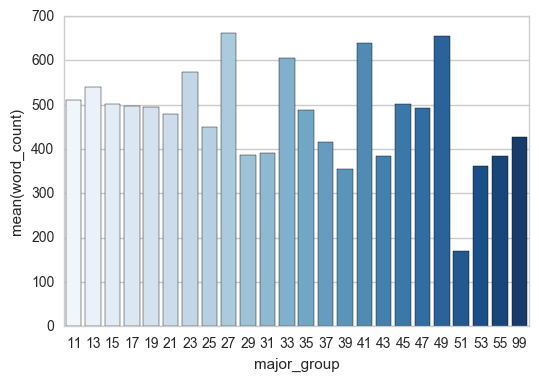

In [18]:
average_count = pd.DataFrame(average_word_count.items(),columns=['major_group','word_count'])
sns.barplot(x ='major_group', y='word_count', data=average_count, palette="Blues")

### Least average word count

In [19]:
for i, row in average_count.sort_values(by='word_count').iloc[:3].iterrows():
    print row[0] + ' ' + onetdict[row[0]] + ': ' + str(int(row[1]))

51 Production Occupations: 170
39 Personal Care and Service Occupations: 354
53 Transportation and Material Moving Occupations: 362


### Most average word count

In [20]:
for i, row in average_count.sort_values(by='word_count',ascending=False).iloc[:3].iterrows():
    print row[0] + ' ' + onetdict[row[0]] + ': ' + str(int(row[1]))

27 Arts, Design, Entertainment, Sports, and Media Occupations: 663
49 Installation, Maintenance, and Repair Occupations: 656
41 Sales and Related Occupations: 640


In [22]:
# Example of a document
df_clean['documents'][45]

u'maintenance groundskeeper janitors and cleaners except maids and housekeeping cleaners maintenance groundskeeper memphis tennessee stonemor partners is currently seeking groundskeeper to join our team at forest hills east this position is responsible for the care maintenance and repairs of the property as well as the safety and security of the employees and visitors of the location we offer competitive benefits package including medical dental life short term disability long term disability tuition reimbursement paid time off more click here for more information stonemor partners is an equal opportunity employer performs all landscape maintenance duties such as lawn mowing weed whacking snow removal etc operates machinery appropriately in safe manner handles the day to day general maintenance duties maintains equipment performs other duties as assigned high school equivalency required years experience in maintenance or related field ability to operate maintenance equipment and machin

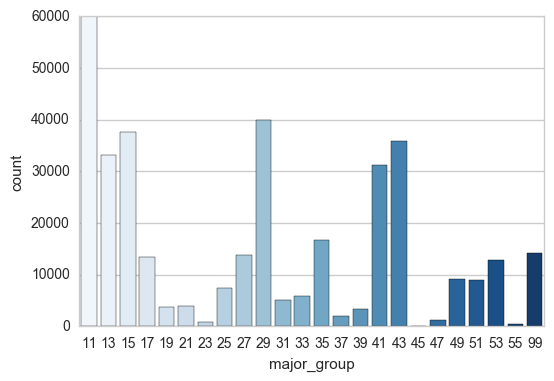

In [23]:
df_clean['major_group'].describe()
sns.countplot('major_group', data=df_clean, palette="Blues")

### Most 

11: Management Occupations has **59960** instances

29: Healthcare Practitioners and Technical Occupations has **39818** instances

15: Computer and Mathematical Occupations has **37580** instances

###  Least

45: Farming, Fishing, and Forestry Occupations has **57** instances

55: Military Specific Occupations has **457** instances

23: Legal Occupations has **817** instances


In [24]:
print "Most"
print "11 Management Occupations: ", len(df_clean['major_group'][df_clean['major_group']=='11'])
print "29 Healthcare Practitioners and Technical Occupations: ", len(df_clean['major_group'][df_clean['major_group']=='29'])
print "15 Computer and Mathematical Occupations: ", len(df_clean['major_group'][df_clean['major_group']=='15'])
print "Least"
print "45 Farming, Fishing, and Forestry Occupations: ", len(df_clean['major_group'][df_clean['major_group']=='45'])
print "55 Military Specific Occupations: ", len(df_clean['major_group'][df_clean['major_group']=='55'])
print "23 Legal Occupations: ", len(df_clean['major_group'][df_clean['major_group']=='23'])

Most
11 Management Occupations:  59960
29 Healthcare Practitioners and Technical Occupations:  39818
15 Computer and Mathematical Occupations:  37580
Least
45 Farming, Fishing, and Forestry Occupations:  57
55 Military Specific Occupations:  457
23 Legal Occupations:  817


In [26]:
print "Unique SOC occupations: ", len(df_clean['onet_code'].unique())

Unique SOC occupations:  489


## Split Training set and testing set 

In [157]:
from sklearn.model_selection import train_test_split
words_train, words_test, tag_train, tag_test =  train_test_split(df_clean, df_clean['major_group'], test_size=0.2)
words_train.to_csv('va_train_clean.csv',index=False, sep=',')
words_test.to_csv('va_test_clean.csv', index=False, sep=',')
#tag_train.to_csv('va_tag_train.csv')
#tag_test.to_csv('va_train_tag_test.csv')

In [237]:
print len(words_train)
print len(words_test)

288000
72000
